In [1]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch

import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

/home/arunasri/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [3]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [4]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [5]:
PRE_TRAINED_ID = "/home/arunasri/ML/notebooks/results/finetune_noresize_final/final_model"

# Load Data

In [6]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [7]:

test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))

In [8]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

In [9]:
# First, ensure that the simplify_timit function is available and works
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        '͡': '', # Simplify affricate to single character
        # Add other necessary substitutions if needed
    }
    phoneme.replace('͡', '') 
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.
    
    Args:
        text: String or iterable containing IPA symbols
        
    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")
    
# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            
            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")
            
            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
test_df = files_to_df(test_files)
test_df.head()


,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðiɡʌnminkɛpizvɪkmkɔɹnɹɾætʌnpɔɪntfɹθɹiʔaʊɹz,"[0, 2218, 2552, 3167, 3750, 4510, 6042, 6696, ...","[2218, 2552, 3167, 3750, 4510, 6042, 6696, 712..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊntʔæskmitukɛɹiɛnʔɔɪliɹæɡlaɪkðæt,"[0, 2160, 2290, 4720, 5200, 5606, 6844, 9148, ...","[2160, 2290, 4720, 5200, 5606, 6844, 9148, 103..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",hivɔnoʊzɹoʊpsðiboʊtskʌmʌnstʌk,"[0, 2200, 3470, 5723, 6725, 8720, 10184, 12365...","[2200, 3470, 5723, 6725, 8720, 10184, 12365, 1..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃiɪzθɪɾɹðɛnaɪæm,"[0, 2270, 4394, 5837, 6767, 8806, 10050, 11350...","[2270, 4394, 5837, 6767, 8806, 10050, 11350, 1..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",histɔɹɪnzivhæduɹizinzfɔɹpɹisɪstinsoʊlɔŋinɛɹnvɛ...,"[0, 2282, 3330, 3789, 5181, 5700, 5983, 8062, ...","[2282, 3330, 3789, 5181, 5700, 5983, 8062, 873..."


In [10]:
timit_vocab = set("".join(test_df['ipa']))
print(f"Number of unique IPA symbols in TIMIT: {(timit_vocab)}")

Number of unique IPA symbols in TIMIT: {'ʊ', 'ɾ', 'ʌ', 'ɪ', 'd', 'ɛ', 'ɡ', 'ʃ', 'f', 'ɔ', 'h', 'ŋ', 'u', 'k', 'θ', 's', 't', 'e', 'w', 'p', 'ə', 'a', 'æ', 'i', 'ʔ', 'n', 'v', 'z', 'm', 'ʒ', 'o', 'ɹ', 'ð', 'j', 'b', 'ɑ', 'l'}


### Cleaning Up Audio

In [11]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

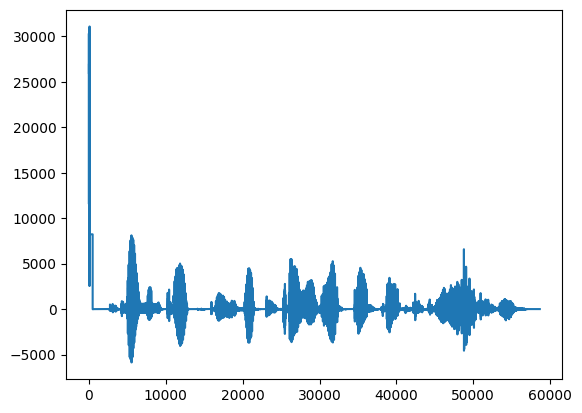

In [12]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(test_df['audio'][0])
plt.show()

In [13]:
test_df['cropped_audio'] = test_df.apply(crop_audio, axis=1)
test_df.head()

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ðiɡʌnminkɛpizvɪkmkɔɹnɹɾætʌnpɔɪntfɹθɹiʔaʊɹz,"[0, 2218, 2552, 3167, 3750, 4510, 6042, 6696, ...","[2218, 2552, 3167, 3750, 4510, 6042, 6696, 712...","[3, 2, 7, 3, 6, 0, 5, 4, 3, 1, 1, 0, 2, -2, 4,..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊntʔæskmitukɛɹiɛnʔɔɪliɹæɡlaɪkðæt,"[0, 2160, 2290, 4720, 5200, 5606, 6844, 9148, ...","[2160, 2290, 4720, 5200, 5606, 6844, 9148, 103...","[-1, 5, 0, 1, 0, 4, 2, 1, 0, -2, -1, 1, 1, 1, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",hivɔnoʊzɹoʊpsðiboʊtskʌmʌnstʌk,"[0, 2200, 3470, 5723, 6725, 8720, 10184, 12365...","[2200, 3470, 5723, 6725, 8720, 10184, 12365, 1...","[11, 11, 11, 12, 11, 11, 12, 9, 3, 3, 1, -4, -..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃiɪzθɪɾɹðɛnaɪæm,"[0, 2270, 4394, 5837, 6767, 8806, 10050, 11350...","[2270, 4394, 5837, 6767, 8806, 10050, 11350, 1...","[-1, -2, -4, -2, 0, -3, -4, 0, -1, -2, -3, -2,..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",histɔɹɪnzivhæduɹizinzfɔɹpɹisɪstinsoʊlɔŋinɛɹnvɛ...,"[0, 2282, 3330, 3789, 5181, 5700, 5983, 8062, ...","[2282, 3330, 3789, 5181, 5700, 5983, 8062, 873...","[2, 1, 4, 3, 0, 1, 2, 6, 1, 4, 4, 1, 3, 5, 0, ..."


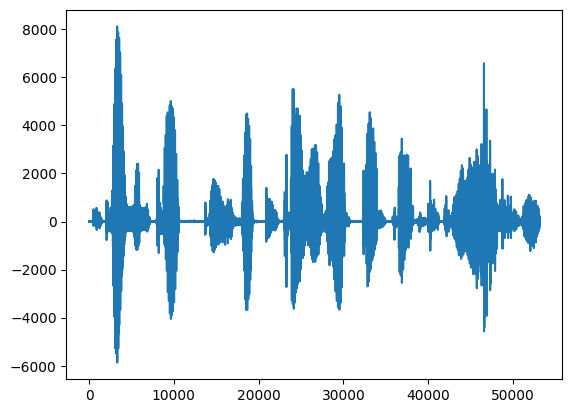

In [14]:
# visualize again, much better!
plt.plot(test_df['cropped_audio'][0])


In [15]:
# Same for test_df
test_df = test_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
test_df = test_df.rename(columns={'cropped_audio': 'audio'})
test_df.head()

,ipa,audio
0,ðiɡʌnminkɛpizvɪkmkɔɹnɹɾætʌnpɔɪntfɹθɹiʔaʊɹz,"[3, 2, 7, 3, 6, 0, 5, 4, 3, 1, 1, 0, 2, -2, 4,..."
1,oʊntʔæskmitukɛɹiɛnʔɔɪliɹæɡlaɪkðæt,"[-1, 5, 0, 1, 0, 4, 2, 1, 0, -2, -1, 1, 1, 1, ..."
2,hivɔnoʊzɹoʊpsðiboʊtskʌmʌnstʌk,"[11, 11, 11, 12, 11, 11, 12, 9, 3, 3, 1, -4, -..."
3,ʃiɪzθɪɾɹðɛnaɪæm,"[-1, -2, -4, -2, 0, -3, -4, 0, -1, -2, -3, -2,..."
4,histɔɹɪnzivhæduɹizinzfɔɹpɹisɪstinsoʊlɔŋinɛɹnvɛ...,"[2, 1, 4, 3, 0, 1, 2, 6, 1, 4, 4, 1, 3, 5, 0, ..."


In [16]:

test_ds = Dataset.from_pandas(test_df)

## retrieve the Total TIMIT Vocab 
we will grab the set of unique timit phonemes and map them to IPA. this will be the vocab all models will be adjusted to fit

In [17]:
processor = AutoProcessor.from_pretrained(PRE_TRAINED_ID)
model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)
BATCH_SIZE = 1

# Tokenize!

In [18]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
print(vocab)

{'A': 267, 'E': 45, 'H': 72, 'I': 20, 'O': 305, 'U': 292, '[PAD]': 310, '[UNK]': 309, '_': 182, 'a': 53, 'ã': 125, 'b': 113, 'b̪': 177, 'b̪͡v': 289, 'b͡ꞵ': 287, 'c': 25, 'cʼ': 229, 'c͡ç': 66, 'd': 176, 'd̼': 118, 'd͡z': 263, 'd͡ð': 244, 'd͡ɮ': 18, 'd͡ʑ': 94, 'd͡ʒ': 280, 'e': 175, 'ẽ': 211, 'e̞': 114, 'ẽ̞': 265, 'f': 139, 'fʼ': 249, 'h': 179, 'i': 245, 'j': 215, 'k': 282, 'kxʼ': 281, 'kǀ': 41, 'kǁ': 61, 'kǂ': 21, 'kǃ': 70, 'kʘ': 79, 'kʼ': 39, 'k̚': 89, 'k͡p': 48, 'k͡x': 198, 'l': 303, 'm': 75, 'm̥': 172, 'n': 102, 'n̥': 28, 'n̼': 169, 'o': 117, 'õ': 119, 'o̞': 62, 'õ̞': 234, 'p': 259, 'pʼ': 286, 'p̚': 149, 'p̪': 273, 'p̪͡f': 105, 'p͡f': 225, 'p͡ɸ': 103, 'q': 130, 'qǀ': 302, 'qǁ': 126, 'qǂ': 299, 'qǃ': 37, 'qʘ': 261, 'qʼ': 58, 'q͡ʡ': 127, 'q͡χʼ': 291, 'q͡ꭓ': 4, 'r': 82, 'r̥': 34, 's': 247, 'sʼ': 200, 't': 307, 'tʼ': 183, 't̚': 241, 't̪͡θʼ': 216, 't̼': 87, 't͡s': 156, 't͡sʼ': 43, 't͡ɕ': 264, 't͡ɬ': 170, 't͡ɬʼ': 164, 't͡ʃ': 91, 't͡ʃʼ': 108, 't͡θ': 140, 'u': 154, 'ũ': 81, 'v': 243, 'w

In [19]:
timit_vocab = set("".join(test_df['ipa']))

In [20]:
# add missing symbols to the vocab
missing_symbols = timit_vocab - set(vocab.keys())
print("missing: ", missing_symbols)
tokenizer.add_tokens(list(missing_symbols))
vocab = tokenizer.get_vocab()
missing_symbols = timit_vocab - set(vocab.keys())
# assert missing is empty
assert len(missing_symbols) == 0
print(vocab)


missing:  set()
{'A': 267, 'E': 45, 'H': 72, 'I': 20, 'O': 305, 'U': 292, '[PAD]': 310, '[UNK]': 309, '_': 182, 'a': 53, 'ã': 125, 'b': 113, 'b̪': 177, 'b̪͡v': 289, 'b͡ꞵ': 287, 'c': 25, 'cʼ': 229, 'c͡ç': 66, 'd': 176, 'd̼': 118, 'd͡z': 263, 'd͡ð': 244, 'd͡ɮ': 18, 'd͡ʑ': 94, 'd͡ʒ': 280, 'e': 175, 'ẽ': 211, 'e̞': 114, 'ẽ̞': 265, 'f': 139, 'fʼ': 249, 'h': 179, 'i': 245, 'j': 215, 'k': 282, 'kxʼ': 281, 'kǀ': 41, 'kǁ': 61, 'kǂ': 21, 'kǃ': 70, 'kʘ': 79, 'kʼ': 39, 'k̚': 89, 'k͡p': 48, 'k͡x': 198, 'l': 303, 'm': 75, 'm̥': 172, 'n': 102, 'n̥': 28, 'n̼': 169, 'o': 117, 'õ': 119, 'o̞': 62, 'õ̞': 234, 'p': 259, 'pʼ': 286, 'p̚': 149, 'p̪': 273, 'p̪͡f': 105, 'p͡f': 225, 'p͡ɸ': 103, 'q': 130, 'qǀ': 302, 'qǁ': 126, 'qǂ': 299, 'qǃ': 37, 'qʘ': 261, 'qʼ': 58, 'q͡ʡ': 127, 'q͡χʼ': 291, 'q͡ꭓ': 4, 'r': 82, 'r̥': 34, 's': 247, 'sʼ': 200, 't': 307, 'tʼ': 183, 't̚': 241, 't̪͡θʼ': 216, 't̼': 87, 't͡s': 156, 't͡sʼ': 43, 't͡ɕ': 264, 't͡ɬ': 170, 't͡ɬʼ': 164, 't͡ʃ': 91, 't͡ʃʼ': 108, 't͡θ': 140, 'u': 154, 'ũ': 

# Update Feature Extraction

In [21]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# Preprocess Data

In [22]:
test_df.head()

,ipa,audio
0,ðiɡʌnminkɛpizvɪkmkɔɹnɹɾætʌnpɔɪntfɹθɹiʔaʊɹz,"[3, 2, 7, 3, 6, 0, 5, 4, 3, 1, 1, 0, 2, -2, 4,..."
1,oʊntʔæskmitukɛɹiɛnʔɔɪliɹæɡlaɪkðæt,"[-1, 5, 0, 1, 0, 4, 2, 1, 0, -2, -1, 1, 1, 1, ..."
2,hivɔnoʊzɹoʊpsðiboʊtskʌmʌnstʌk,"[11, 11, 11, 12, 11, 11, 12, 9, 3, 3, 1, -4, -..."
3,ʃiɪzθɪɾɹðɛnaɪæm,"[-1, -2, -4, -2, 0, -3, -4, 0, -1, -2, -3, -2,..."
4,histɔɹɪnzivhæduɹizinzfɔɹpɹisɪstinsoʊlɔŋinɛɹnvɛ...,"[2, 1, 4, 3, 0, 1, 2, 6, 1, 4, 4, 1, 3, 5, 0, ..."


# Fine-Tune Model

In [23]:
print(tokenizer.get_vocab())  # This will print the vocabulary, including the newly added token


{'A': 267, 'E': 45, 'H': 72, 'I': 20, 'O': 305, 'U': 292, '[PAD]': 310, '[UNK]': 309, '_': 182, 'a': 53, 'ã': 125, 'b': 113, 'b̪': 177, 'b̪͡v': 289, 'b͡ꞵ': 287, 'c': 25, 'cʼ': 229, 'c͡ç': 66, 'd': 176, 'd̼': 118, 'd͡z': 263, 'd͡ð': 244, 'd͡ɮ': 18, 'd͡ʑ': 94, 'd͡ʒ': 280, 'e': 175, 'ẽ': 211, 'e̞': 114, 'ẽ̞': 265, 'f': 139, 'fʼ': 249, 'h': 179, 'i': 245, 'j': 215, 'k': 282, 'kxʼ': 281, 'kǀ': 41, 'kǁ': 61, 'kǂ': 21, 'kǃ': 70, 'kʘ': 79, 'kʼ': 39, 'k̚': 89, 'k͡p': 48, 'k͡x': 198, 'l': 303, 'm': 75, 'm̥': 172, 'n': 102, 'n̥': 28, 'n̼': 169, 'o': 117, 'õ': 119, 'o̞': 62, 'õ̞': 234, 'p': 259, 'pʼ': 286, 'p̚': 149, 'p̪': 273, 'p̪͡f': 105, 'p͡f': 225, 'p͡ɸ': 103, 'q': 130, 'qǀ': 302, 'qǁ': 126, 'qǂ': 299, 'qǃ': 37, 'qʘ': 261, 'qʼ': 58, 'q͡ʡ': 127, 'q͡χʼ': 291, 'q͡ꭓ': 4, 'r': 82, 'r̥': 34, 's': 247, 'sʼ': 200, 't': 307, 'tʼ': 183, 't̚': 241, 't̪͡θʼ': 216, 't̼': 87, 't͡s': 156, 't͡sʼ': 43, 't͡ɕ': 264, 't͡ɬ': 170, 't͡ɬʼ': 164, 't͡ʃ': 91, 't͡ʃʼ': 108, 't͡θ': 140, 'u': 154, 'ũ': 81, 'v': 243, 'w

In [24]:
# # save pretrained model's processor to trial 9
# model = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"
# processor = AutoProcessor.from_pretrained(model)
# processor.save_pretrained("/home/arunasri/ML/notebooks/results/a100_noresize_structured_v2/trial_9")

In [25]:
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
def evaluate_model(test_df, processor, model):
    """
    Evaluate the model on test data and calculate statistics.

    Args:
        test_df: DataFrame with 'audio' (input values) and 'ipa' (labels).
        processor: Wav2Vec2Processor for processing input and labels.
        model: Pre-trained Wav2Vec2 model.
    Returns:
        avg_weighted_dist: Average weighted feature edit distance.
        std_weighted_dist: Standard deviation of weighted feature distances.
    """
    assert "audio" in test_df.columns, "Missing 'audio' column in test_df!"
    assert "ipa" in test_df.columns, "Missing 'ipa' column in test_df!"

    def collate_fn(batch):
        """
        Collate function to batch inputs and process them.
        """
        audios = [torch.tensor(item['audio'], dtype=torch.float32) for item in batch]
        labels = [item['ipa'] for item in batch]  # Collect ground truth IPA labels

        # Pad audio sequences
        padded_audios = pad_sequence(audios, batch_first=True, padding_value=-100)

        # Perform feature extraction
        inputs = processor.feature_extractor(
            padded_audios.numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            padding=False
        )

        return {
            "input_values": inputs["input_values"],
            "attention_mask": inputs.get("attention_mask"),
            "labels": labels,  # Include ground truth labels in the batch
        }

    # Prepare DataLoader
    dataset = test_df.to_dict(orient="records")
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # Evaluate model
    model.eval()
    weighted_distances = []  # Store weighted feature distances for statistics
    total_cer = []
    for batch in data_loader:
        input_values = batch["input_values"]
        ground_truth_labels = batch["labels"]  # Get the ground truth IPA labels

        # Move input values to the appropriate device
        input_values = input_values.to(model.device)

        with torch.no_grad():
            outputs = model(input_values=input_values)
            logits = outputs.logits

            # Decode predictions
            predicted_ids = torch.argmax(logits, dim=-1)
            predictions = processor.batch_decode(predicted_ids, skip_special_tokens=True)
            predictions = [pred.replace(' ', '') for pred in predictions]  # Strip spaces
        # Call panphon_model_eval with label and predicted IPA
        results = panphon_model_eval(ground_truth_labels, predictions)

        # Append weighted feature edit distances
        weighted_distances.append(results['weighted_feature_dist'])
        total_cer.append(results['cer_score'])

        # Output intermediate results
        # print("predictions and ground truth", predictions, ground_truth_labels)
        print(f"Weighted feature edit distance: {results['weighted_feature_dist']}")
        print(f"CER: {results['cer_score']}")

    # Calculate statistics
    weighted_distances = np.array(weighted_distances)
    avg_weighted_dist = np.mean(weighted_distances)
    std_weighted_dist = np.std(weighted_distances)

    avg_cer = np.mean(total_cer)
    std_cer = np.std(total_cer)


    return avg_weighted_dist, std_weighted_dist, avg_cer, std_cer


# Evaluate the model9
small_test_df = test_df.head(1)  # Use a subset for debugging
avg_distance, std_distance, avg_cer, std_cer = evaluate_model(test_df, processor, model)
print(f"Final Results - Average Weighted Distance: {avg_distance}, Standard Deviation: {std_distance}")
print(f"Final Results - Average CER: {avg_cer}, Standard Deviation: {std_cer}")


/home/arunasri/ML/venv/lib/python3.8/site-packages/panphon/distance.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dogol_prime = yaml.load(f.read())


prediction: ðəɡʌnmənkɛptizvɪkəmkɔɹɾɹɾɛtʌnpɔɪntfɹθɹiaʊɹz
ground_truth: ðiɡʌnminkɛpizvɪkmkɔɹnɹɾætʌnpɔɪntfɹθɹiʔaʊɹz
Weighted feature edit distance: 24.625
CER: 0.16666666666666666
prediction: oʊnʔæskmitukɛɹinʔɔɪliɹæɡlaɪkðæt
ground_truth: oʊntʔæskmitukɛɹiɛnʔɔɪliɹæɡlaɪkðæt
Weighted feature edit distance: 14.5
CER: 0.06060606060606061
prediction: hivɔnðoʊzɹoʊpsðəboʊtskʌmʌnstʌk
ground_truth: hivɔnoʊzɹoʊpsðiboʊtskʌmʌnstʌk
Weighted feature edit distance: 7.875
CER: 0.06896551724137931
prediction: ʃiɪzθɪnɹðɛnaɪæm
ground_truth: ʃiɪzθɪɾɹðɛnaɪæm
Weighted feature edit distance: 1.25
CER: 0.06666666666666667
prediction: histɔɹinzivhæduɹizinzfɹpɹsɪstiŋsoʊlɔŋinðɛɹnvɛstiɡeɪʃnz
ground_truth: histɔɹɪnzivhæduɹizinzfɔɹpɹisɪstinsoʊlɔŋinɛɹnvɛstiɡeɪʃints
Weighted feature edit distance: 37.5625
CER: 0.14035087719298245
prediction: oʊɾæskmiɾikɛɹiʔinɔliɹæɡlaɪkðæt
ground_truth: oʊɾæsmiɾikɹiʔɛnɔliɹæɡlaɪkðæt
Weighted feature edit distance: 14.875
CER: 0.10714285714285714
prediction: ʔʌðɹwaɪzjumeɪbisæɾəldwiθeɪɡʊdsaɪz

In [26]:
def cer(pred, label):
    distances = np.zeros((len(pred) + 1, len(label) + 1))

    for t1 in range(len(pred) + 1):
        distances[t1][0] = t1

    for t2 in range(len(label) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(pred) + 1):
        for t2 in range(1, len(label) + 1):
            if (pred[t1-1] == label[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(pred)][len(label)] / len(label)

In [ ]:
from transformers import Trainer
model = AutoModelForCTC.from_pretrained(PRE_TRAINED_ID)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    eval_dataset=test_ds_prepared,
    tokenizer=tokenizer
)

# Evaluate

In [ ]:
import wandb
eval_results = trainer.evaluate()
print(eval_results)
wandb.log(eval_results)

In [48]:
def predict(model, wav_file):
    speech = audio_file_to_array(wav_file)
    input_values = processor(speech, sampling_rate=16000, return_tensors="pt").input_values.type(torch.float32).to(model.device)

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return processor.decode(predicted_ids[0])
    